# <p style="color:red">**Image-Based Fire Detection: Automated Classification System Development**<p>

## <p style="color:black"> Buisness Case: Based on the provided image data, our objective is to develop a classification system that categorizes images into two distinct classes Fire and Not-Fire

### **IMPORT NECESSARY LIBRARY**

In [1]:
import numpy as np
import pandas as pd
import cv2
import os 
import pygame
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import pygame
import threading
import gradio as gr
from PIL import Image 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix

# supress warnings
import warnings
warnings.filterwarnings("ignore")


pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


### **DATA LOADING**

In [2]:
!pip install split-folders

In [3]:
import splitfolders
splitfolders.ratio("/kaggle/input/fire-dataset/data",output="output",seed=1234, ratio=(0.8,0.1,0.1))

Copying files: 4416 files [00:51, 85.68 files/s] 


In [4]:
train_dir = "/kaggle/working/output/train"
val_dir   = "/kaggle/working/output/val"
test_dir  = "/kaggle/working/output/test"

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,                
                                   rotation_range=20,              
                                   zoom_range=0.2,                 
                                   width_shift_range=0.2,          
                                   height_shift_range=0.2,         
                                   shear_range=0.2,                
                                   horizontal_flip=True,           
                                   brightness_range=[0.5, 1.5],   
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=(1./255))

test_datagen = ImageDataGenerator(rescale=(1./255))

In [6]:
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224,224),
                                              batch_size=32,
                                              color_mode='rgb',
                                              class_mode='binary')

val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size=(224,224),
                                          batch_size=32,
                                          color_mode='rgb',
                                          class_mode='binary')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(224,224),
                                            batch_size=32,
                                            color_mode='rgb',
                                            class_mode='binary')

Found 3532 images belonging to 2 classes.
Found 440 images belonging to 2 classes.
Found 444 images belonging to 2 classes.


In [7]:
# Get classes indices
train_set.class_indices

{'fire': 0, 'non_fire': 1}

### **SEPARATE LABEL FROM TEST SET**

In [8]:
X_test, y_test = next(test_set)

In [9]:
print(X_test.shape)
print(y_test)

(32, 224, 224, 3)
[1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 0. 0.]


### **VISUALISE TRAINING IMAGES**

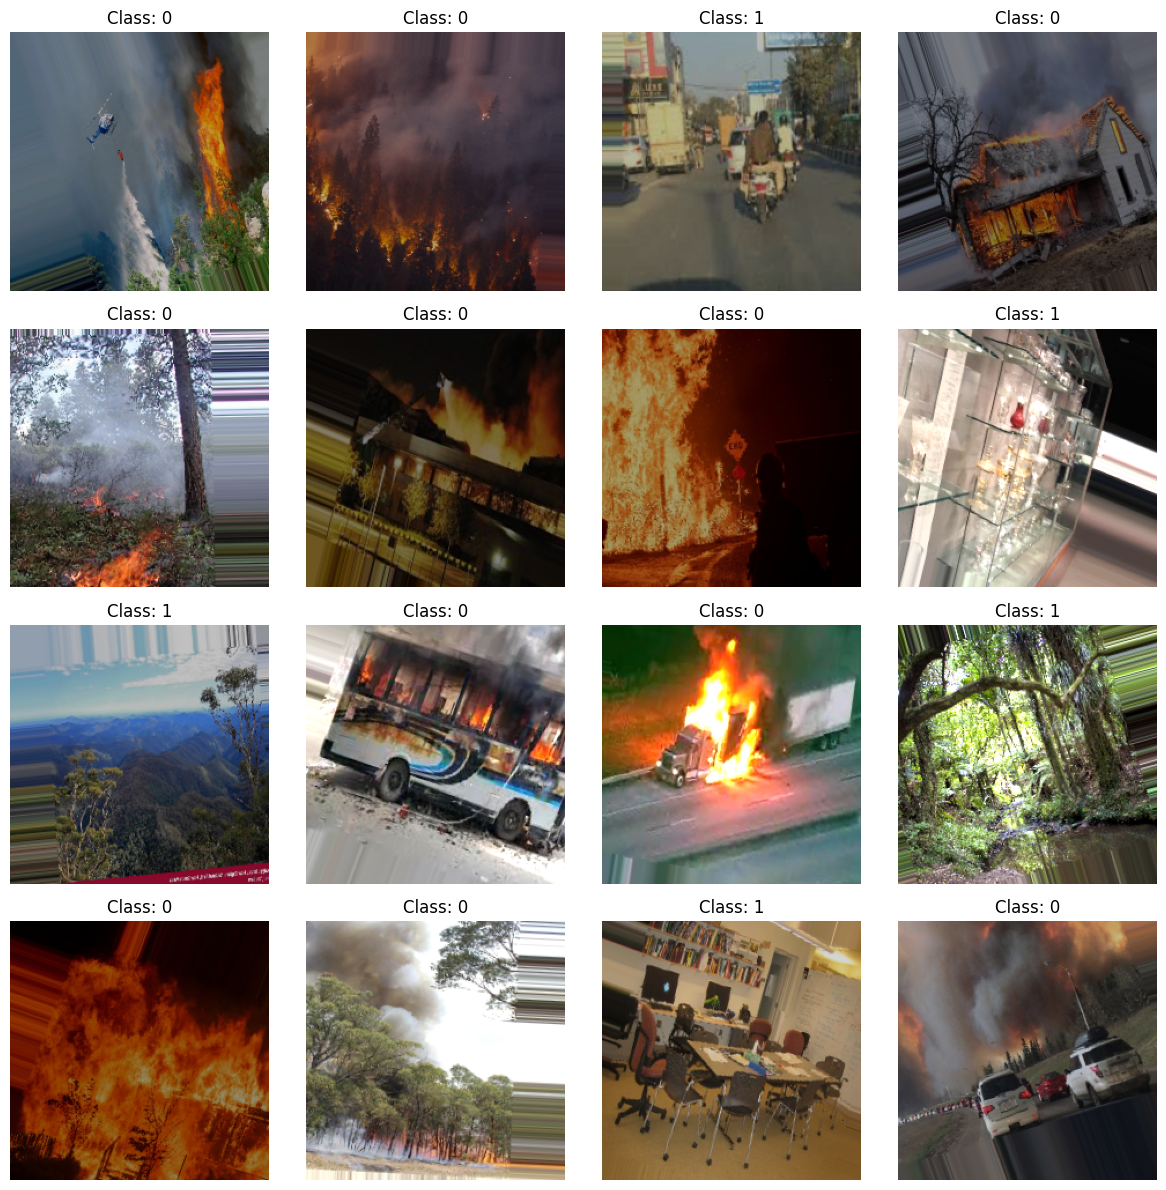

In [10]:
# Seprate the images and labels from training set
img, label = next(train_set)

plt.figure(figsize=(12, 12))
for i in range(16):  
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])  
    plt.title(f'Class: {int(label[i])}') 
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Get class labels from training set 
class_labels = train_set.classes
unique_classes = np.unique(class_labels)

# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=class_labels)

# Create dict of class weights
class_weight_dict = dict(zip(unique_classes, class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8699507389162562, 1: 1.1757656458055925}


### **CREATE SEQUENTIAL MODEL**

In [6]:
# Create Sequential model
model = Sequential()

# Add Convolutional layers with Batch Normalization and Dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Fully Connected layers with Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(1, activation='sigmoid'))


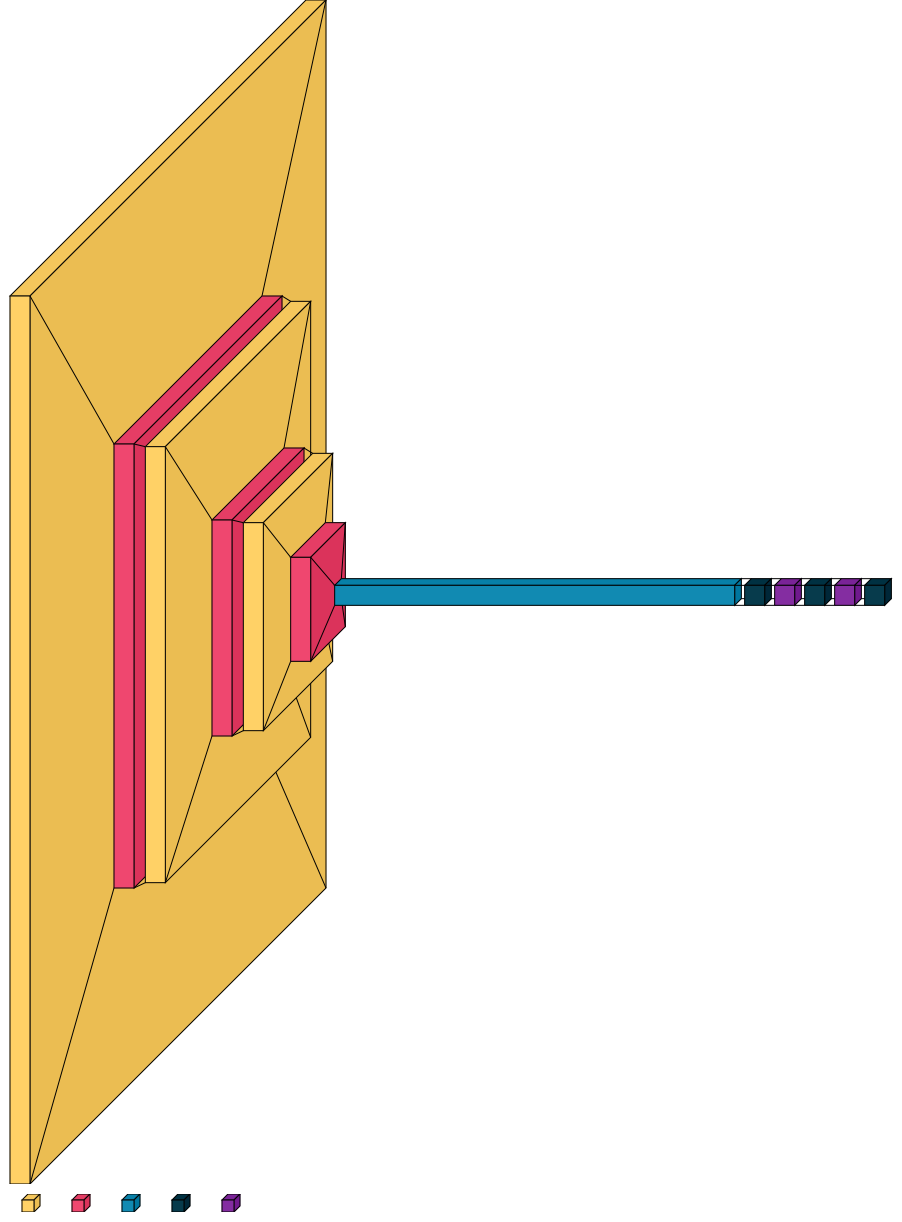

In [7]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,281 (42.64 MB)

 Trainable params: 11,177,281 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

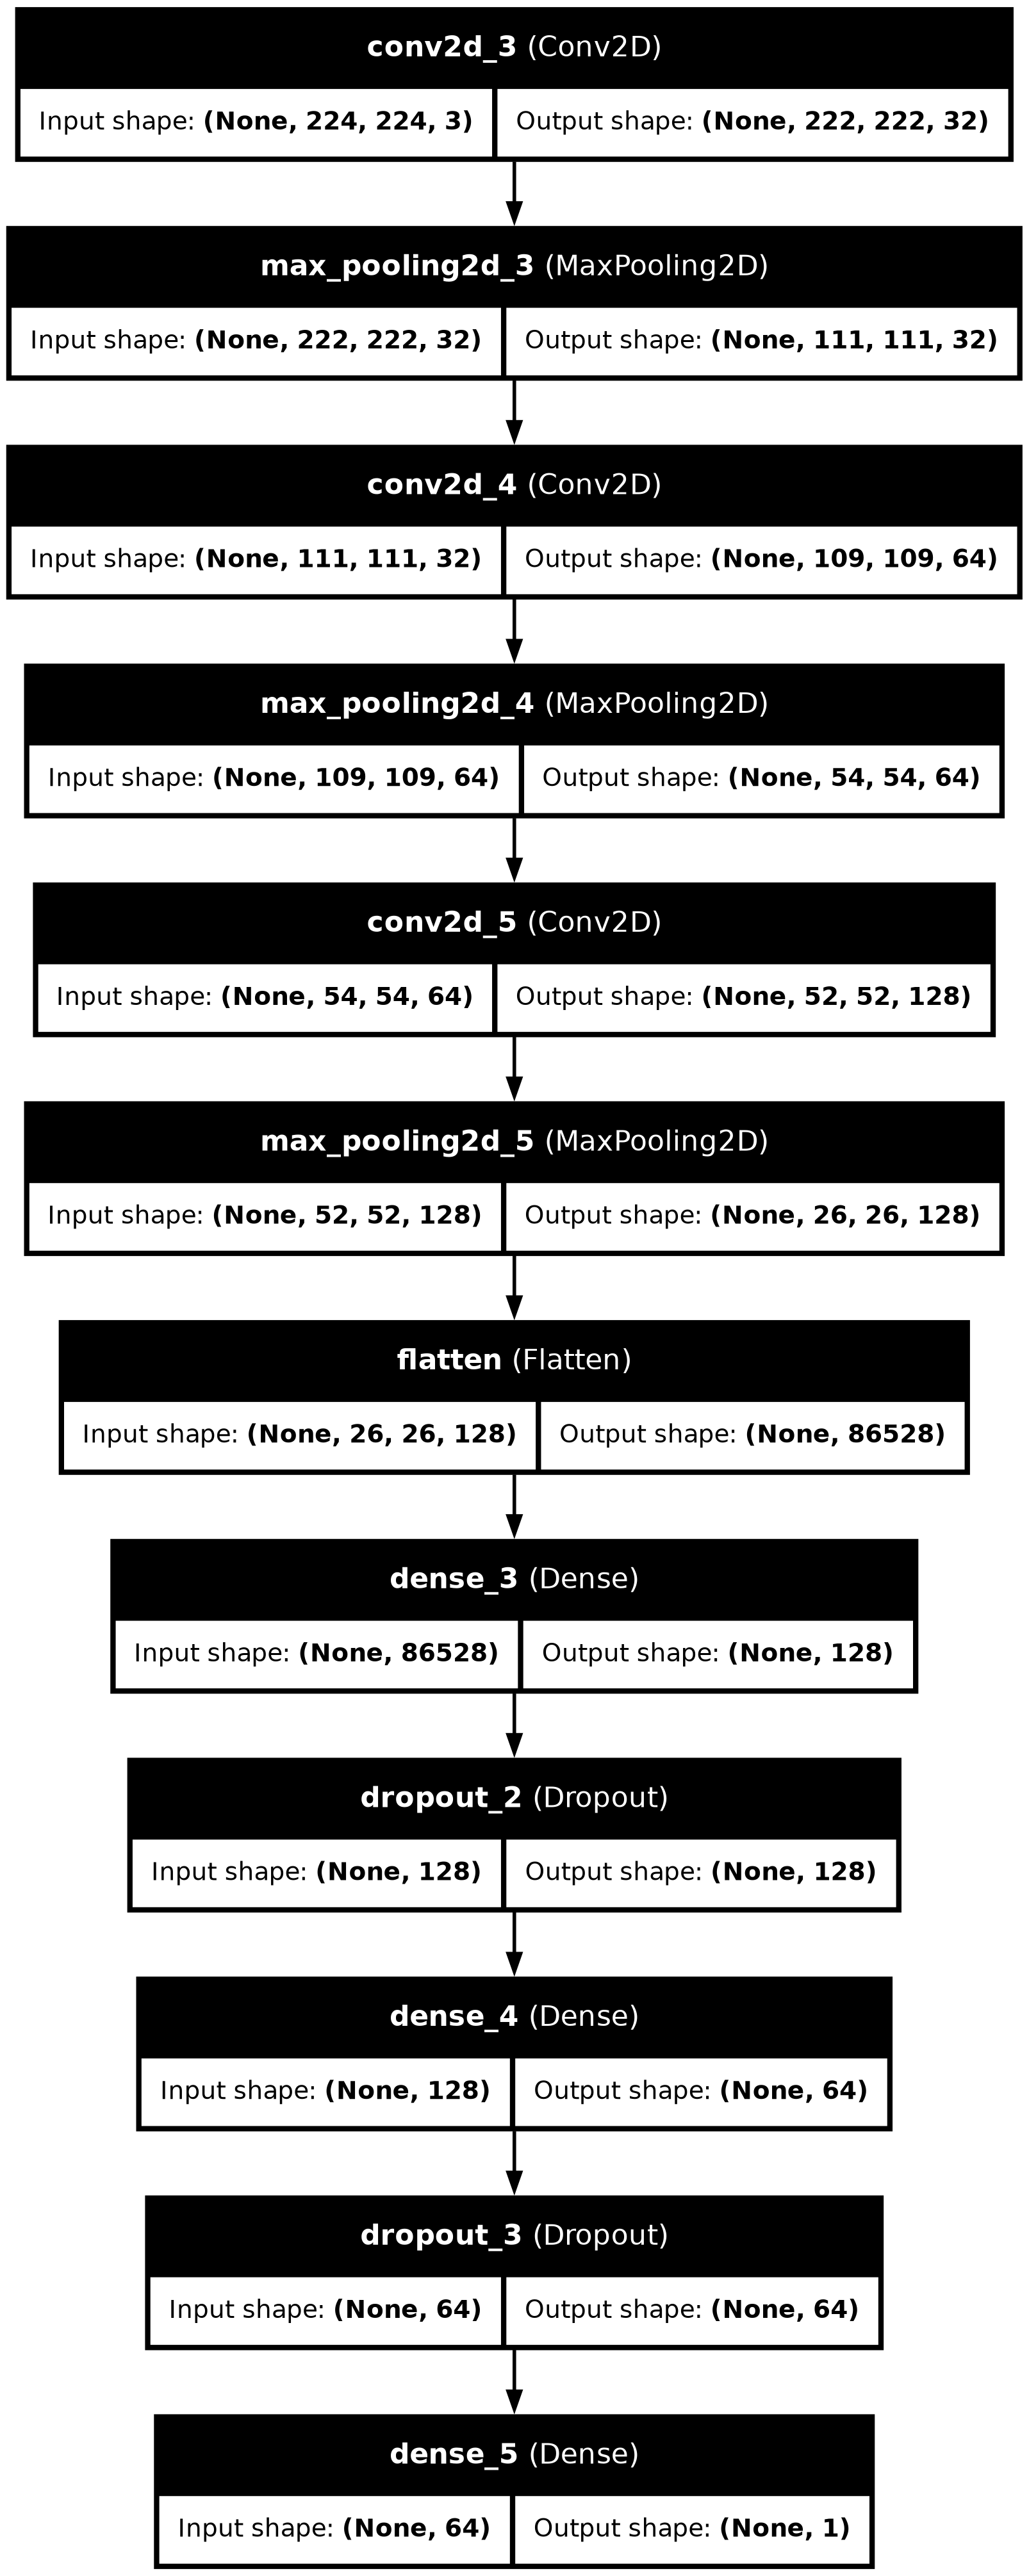

In [15]:
plot_model(model, to_file='fire_detection_model.png', show_shapes=True, show_layer_names=True)

### **COMPILE AND TRAIN MODEL**

In [16]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [17]:
# Use ModelCheckPoint and Early stopping to avoid overfitting problem
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1)

modelCheckpoint = ModelCheckpoint(filepath='fire_detection_model.keras',
                                  monitor='val_loss',
                                  verbose=True,
                                  save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              min_lr=1e-6)


In [18]:
# fit model for training
history = model.fit(train_set,
                    epochs=50,
                    validation_data=val_set,
                    class_weight=class_weight_dict,
                    callbacks=[early_stop, modelCheckpoint])

Epoch 1/50


I0000 00:00:1732455519.863691     146 service.cc:145] XLA service 0x7dd2a4001d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732455519.863753     146 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/111 ━━━━━━━━━━━━━━━━━━━━ 22:48 12s/step - accuracy: 0.6250 - loss: 0.6882

I0000 00:00:1732455526.230252     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7232 - loss: 0.5753
Epoch 1: val_loss improved from inf to 0.31700, saving model to fire_detection_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 72s 537ms/step - accuracy: 0.7245 - loss: 0.5733 - val_accuracy: 0.8545 - val_loss: 0.3170
Epoch 2/50
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8355 - loss: 0.3886
Epoch 2: val_loss did not improve from 0.31700
111/111 ━━━━━━━━━━━━━━━━━━━━ 58s 489ms/step - accuracy: 0.8357 - loss: 0.3882 - val_accuracy: 0.8636 - val_loss: 0.3517
Epoch 3/50
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8645 - loss: 0.3233
Epoch 3: val_loss improved from 0.31700 to 0.29490, saving model to fire_detection_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 58s 494ms/step - accuracy: 0.8647 - loss: 0.3230 - val_accuracy: 0.8909 - val_loss: 0.2949
Epoch 4/50
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8717 - loss: 0.3087
Epoch 4: val_loss improved from 0.29490 to 0.25031, saving model t

### **PLOT TRAINING AND VALIDATION ACCURACY AS WELL AS LOSS**

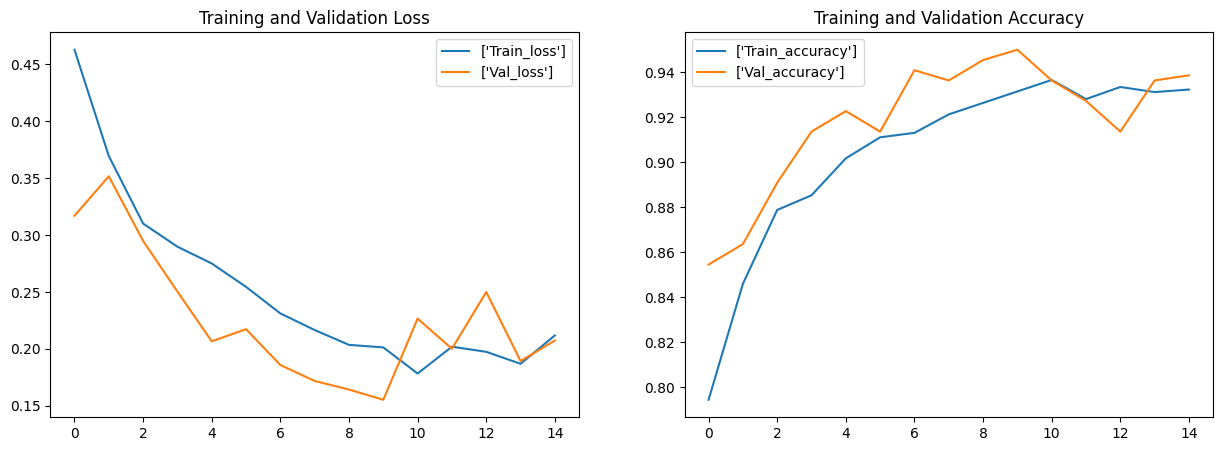

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label=['Train_loss'])
plt.plot(history.history['val_loss'], label=['Val_loss'])
plt.title("Training and Validation Loss")
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label=['Train_accuracy'])
plt.plot(history.history['val_accuracy'], label=['Val_accuracy'])
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


### **MODEL EVALUATION**

In [20]:
train_loss, train_accuracy = model.evaluate(train_set)
test_loss, test_accuracy = model.evaluate(test_set)
data = pd.DataFrame({'Loss': [train_loss, test_loss],'Accuracy': [train_accuracy, test_accuracy]}, 
                    index=['Train', 'Test'])
data

111/111 ━━━━━━━━━━━━━━━━━━━━ 55s 494ms/step - accuracy: 0.9434 - loss: 0.1526
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.9229 - loss: 0.1731


,Loss,Accuracy
Train,0.153440,0.942809
Test,0.189897,0.927928


In [21]:
# Reset the generator to ensure it starts from the beginning
test_set.reset()

In [22]:
# Gather predictions and true labels
y_pred = []
y_true = []

for _ in range(len(test_set)):
    batch_images, batch_labels = next(test_set)
    predictions = model.predict(batch_images)
    y_pred.extend(predictions)
    y_true.extend(batch_labels)

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

print(f"Processed samples: {len(y_pred)}, Total samples: {test_set.samples}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Processed samples: 444, Total samples: 444


In [23]:
# Convert predictions to binary classes
y_pred_classes = (y_pred > 0.5).astype(int)

f1 = f1_score(y_true, y_pred_classes)
print("F1 Score:", f1*100)

F1 Score: 91.87817258883248


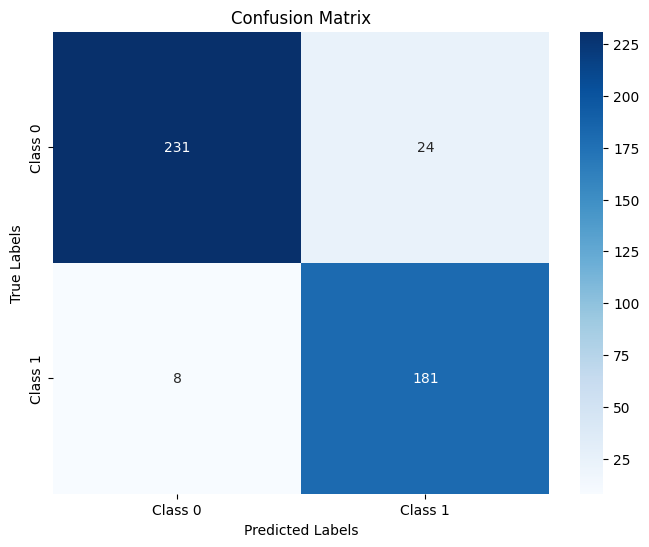

In [24]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### **LOAD MODEL TO MAKE PREDICTION ON UNSEEN DATA**

In [55]:
model = load_model('/kaggle/working/fire_detection_model.keras')

img_path = "/kaggle/working/output/test/non_fire/126_jpg.rf.a337cae54c43d937478be122cb97afc3.jpg"

# Load the image with target size
img = load_img(img_path, target_size=(224,224))

# Convert image to array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
print("Preprocessed image shape:", img_array.shape)

Preprocessed image shape: (1, 224, 224, 3)


In [56]:
prediction = model.predict(img_array)
prediction_binary = (prediction > 0.5).astype(int)
if prediction_binary == 0:
    print("Fire Detected")
else:
    print("No Fire Detected")
print(f"Prediction Probability: {prediction[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
No Fire Detected
Prediction Probability: 1.00


* Test the model using different types of images, and our model make 95% correct prediction.

## <p style="color:red"> **Test the model on images. If fire is detected, the alarm will be raised.**

In [2]:
# Load trained model
model = load_model("fire_detection_model.keras")

In [3]:
# Preprocess imput image
def preprocess_image(image):
    image = image.resize((224, 224)) 
    image_array = np.array(image) / 255.0  
    image_array = np.expand_dims(image_array, axis=0)  
    return image_array

# Prediction function
def predict_fire(image):
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)[0][0]  
    if prediction < 0.5:
        return "Fire Detected", True
    else:
        return "No Fire Detected", False



In [4]:
# pygame for sound playback
pygame.mixer.init()
alarm_thread = None

def play_alarm():
    global alarm_thread
    pygame.mixer.music.load("sound.mp3") 
    pygame.mixer.music.play(-1)  

def stop_alarm():
    pygame.mixer.music.stop()

# Main processing function
def process_image(image):
    global alarm_thread
    if image is None:  
        stop_alarm()
        return "No Image"

    result, is_fire = predict_fire(image)
    if is_fire:
        if not pygame.mixer.music.get_busy():  
            alarm_thread = threading.Thread(target=play_alarm)
            alarm_thread.start()
    else:
        stop_alarm()
    return result


In [5]:
# Gradio interface
interface = gr.Interface(fn=process_image,
                         inputs=gr.Image(type="pil", label="Upload Image"),  
                         outputs=gr.Textbox(label="Prediction"),
                         title="Image Base Fire Detection",
                         description="Upload an image to detect fire. An alarm will sound if fire is detected. The alarm stops when the image is cleared.",)
interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.31.5, however version 4.44.1 is available, please upgrade.
--------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
